# Checking ML

In [1]:
import copy
import math
import collections
from scipy import interpolate as interp
from scipy import signal
import scipy
import pandas as pd
import glob
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets


import resurfemg


In [2]:
import os

In [3]:
import sys
# go to machine
sys.path.insert(0, '../resurfemg')
import helper_functions as hf

from config import Config
import ml as ml

In [4]:
prepro = '../not_pushed/topspin_data_anonymized/preprocessedb'
#C:\Projects\ReSurfEMG\not_pushed\topspin_data_anonymized\preprocessedb

In [5]:
file_directory_list = glob.glob(os.path.join(prepro, '**/*.npy'),recursive=True,)

In [6]:
data = np.load(file_directory_list[1])
data

array([-1.23449254e-05, -6.23982222e-04, -4.00554966e-04, ...,
       -1.31425369e-04, -1.08339252e-04, -7.93833344e-06])

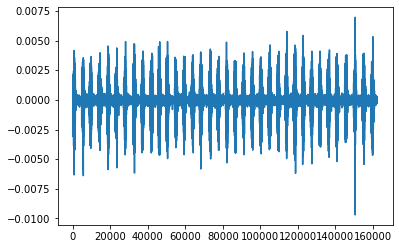

In [7]:
plt.plot(data)

In [10]:
output_folder = '../not_pushed/ml_output'
model_file = '../ml_models/finalized_svm_model_in_111.sav'

takes a really long time?

In [ ]:
ml.applu_model(prepro, model_file, output_folder)

# New Synthetic data function

In [ ]:
import copy
import math
import collections
from scipy import interpolate as interp
from scipy import signal
import scipy
import pandas as pd
import glob
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
import neurokit2 as nk

import resurfemg
import resurfemg.helper_functions as hf

In [ ]:
# EMG generator

y_emg = np.array([i/emg_sample_rate for i in range(int(t_start*emg_sample_rate), int(t_end*emg_sample_rate))]) # Time axis

# Reference signal/Pattern generator
emg_block = (signal.square(y_emg*rr/60*2*np.pi + 0.5, ie_fraction)+1)/2
for i, t_occ in enumerate(t_occs):
     n_occ = int(t_occ*emg_sample_rate)
     emg_block[n_occ:n_occ+int(emg_sample_rate*60/rr)+1] = (signal.square(np.arange(int(emg_sample_rate*60/rr)+1)/emg_sample_rate*rr/60*2*np.pi, ie_fraction)+1)/2

# Simulate up- and downslope dynamics of EMG
pattern_gen_emg = np.zeros((len(y_emg),))
for i in range(1, len(y_emg)):
    if (emg_block[i-1]-pattern_gen_emg[i-1]) > 0:
        pattern_gen_emg[i] = pattern_gen_emg[i-1]+(emg_block[i-1]-pattern_gen_emg[i-1])/(tau_mus_up*emg_sample_rate)
    else:
        pattern_gen_emg[i] = pattern_gen_emg[i-1]+(emg_block[i-1]-pattern_gen_emg[i-1])/(tau_mus_down*emg_sample_rate)


# ECG component
t_ecg = (t_end - t_start)
ecg_sample_rate = emg_sample_rate
part_ecg = nk.ecg_simulate(duration=t_ecg, sampling_rate=int(ecg_sample_rate*1.5), heart_rate=80/1.5) 
    # NB The simulated ECG is condensed, such that it results into more physiological QRS complex widths
part_ecg = part_ecg[:len(y_emg)]

# Respiratory EMG component
rng = np.random.default_rng(seed=42)
part_emg = pattern_gen_emg * np.random.normal(0, 0.5, size=(len(y_emg), ))

# Noise and drift componentss
part_noise = np.random.normal(0, 0.5, size=(len(y_emg), ))
part_drift = np.zeros((len(y_emg),))
b, a  = scipy.signal.butter(4, 0.1, btype='low', analog=False, output='ba', fs=emg_sample_rate)
# part_drift = scipy.signal.filtfilt(b, a, np.random.normal(0, 0.5, size=(len(y_emg), )))

# Mix channels
x_emg = np.zeros((3,len(y_emg)))
x_emg[0, :] = 200*part_ecg + 0.05 * part_emg + 1 * part_noise + 20 * part_drift
x_emg[1, :] = 200*part_ecg + 4 * part_emg + 1 * part_noise + 20 * part_drift
x_emg[2, :] = 200*part_ecg + 8 * part_emg + 1 * part_noise + 20 * part_drift

data_emg_samples = x_emg